### First things first

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

from sklearn.naive_bayes import MultinomialNB

In [3]:
!ls

Baseline.ipynb
Untitled16.ipynb
V1.ipynb
train.csv


In [4]:
df = pd.read_csv('train.csv').drop(columns = 'id')
df.head()

,text,is_humor,humor_rating,humor_controversy,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[['text']], df['is_humor'], test_size = 0.2, random_state = 21)

In [6]:
X_train.describe()

,text
count,6400
unique,6400
top,How can you be called a believer if you don't ...
freq,1


In [7]:
total = len(y_train)
print('% of positives is ', round(y_train.sum()/total, 2)) #'% of positives is {:.2f}'.format(y_train.sum()/total)
print('% of negatives is ', round((total - y_train.sum())/total, 2)) #'% of negatives is {:.2f}'.format((total - y_train.sum())/total)

% of positives is  0.61
% of negatives is  0.39


(array([2466.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3934.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

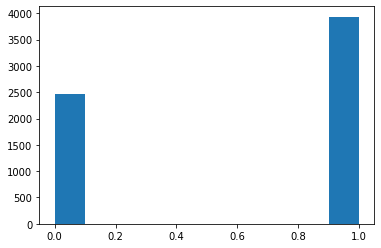

In [8]:
plt.hist(y_train)

In [9]:
def stemmer(text, stemmer):
    return(' '.join([stemmer.stem(w) for w in word_tokenize(text)]))

def count_words(input):
    """ Returns number of occurences of characters specified in char """     
    return len(input.split())

def remove_punctuation(s_input, include_char = None):
    """ Returns input string without punctuation """
    import string as String
    punct = String.punctuation
    
    if not include_char is None:
        index = String.punctuation.index(include_char)
        punct = String.punctuation[:index] + String.punctuation[(index + 1):]
        
    punct += '\n'
        
    translator = str.maketrans(punct, ' '*len(punct))
    
    return s_input.translate(translator)

def remove_stopwords(text, use_stopwords = None, df = True, exclude_number = True):
    """ Returns input string removing stopwords from it. """
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    if use_stopwords is None:
        use_stopwords = set(stopwords.words("english"))
        
    if df:
        new_text = word_tokenize(text)
        if exclude_number:
            new_text = [word for word in new_text if not word.isnumeric()]
        new_text = " ".join([word for word in new_text if word not in use_stopwords])
    else:
        new_text = ""
        for word in text:
            if word not in use_stopwords:
                new_text += word + " "

    return new_text

def sep_upper(text):
    """ Take a text as input and insert space before every uppercase letter. """
    
    new_text = ""
    for letter in text:
        if letter.isupper():
            new_text += " " + letter
        else:
            new_text += letter
    
    return new_text

def remove_space(text):
    return(re.sub(' +',' ',text)) 

In [10]:
def pre_proc(text_col):
    text_col = text_col.apply(remove_punctuation) # removes String.punctuation characters
    #text_col = text_col.apply(remove_stopwords)   # removes english stopwords 
    text_col = text_col.str.replace('[^\w\s]','').str.strip() # and removes whitespaces
    text_col = text_col.apply(sep_upper) # adds space before an uppercase
    text_col = text_col.str.lower() # lowercase
    
    return text_col

In [11]:
X_train.text = pre_proc(X_train.text)
X_test.text = pre_proc(X_test.text)

In [12]:
X_train['qtd_words'] = X_train.text.apply(count_words)
X_test['qtd_words'] = X_test.text.apply(count_words)

In [13]:
X_test.head()

,text,qtd_words
1705,like if i had information i could dismiss fro...,15
6185,since my wife left i ve bought a harley d...,36
899,there s a man walking a tight rope 100ft bel...,33
7453,my wife yelled at me saying you weren t ev...,26
2772,bipolar depression is technically referred to...,21


In [14]:
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numerical_data = FunctionTransformer(lambda x: x[['qtd_words']], validate=False)

process_and_join_features = Pipeline([('features', FeatureUnion([
    ('text_features', Pipeline([('selector', get_text_data), 
                                ('vec', CountVectorizer())])),
    ('nume_features', Pipeline([('selector', get_numerical_data), 
                                ('scaler', MinMaxScaler())]))
    ])),
    ('clf', MultinomialNB())
                                      ])

In [15]:
process_and_join_features.fit(X_train, y_train)
predicted_CountVectorizer = process_and_join_features.predict(X_test)

In [16]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, predicted_CountVectorizer))

0.85125


In [36]:
df.iloc[1705].text

'Like if i had information i could dismiss from my brain it would be this'

In [37]:
X_test.loc[1705].text

' like if i had information i could dismiss from my brain it would be this'